In [1]:
from py_session import py_session
import numpy as np
import os
import pandas as pd
import cv2
import natsort
import pandas as pd
from skimage.io import imread
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import pickle
import imageio

In [2]:
# load data on the outcomes (residualized like, comment, share)
label = pd.read_csv('/n/holylfs05/LABS/jyang_lab/Lab/tiktok_sample/enga_res_emb.csv')

# get video directory for training
video_dir = '/n/holylfs05/LABS/jyang_lab/Lab/tiktok_sample/training/frame/'
video_name = os.listdir(video_dir)

# specify directory to save output
out_dir = '/n/holylfs05/LABS/jyang_lab/Lab/tiktok_sample/sales_panel/engagement_heatmap/'

### train 3D CNN

In [3]:
# load video frames and filter to videos >= 15 seconds and have engagement data
v = [] 

for i, video in enumerate(video_name):
    frame_name = os.listdir(video_dir + '/' + video)
    frame_name = natsort.natsorted(frame_name)
        
    if len(frame_name) >= 15 and video in label['video_full_id'].values:
        v.append(video)

label = label[label['video_full_id'].isin(v)]

In [4]:
# use share/like/comment as the outcome
share = label['share_res'].values.astype(float)
#like = label['like_emb_res'].values.astype(float)
#comment = label['comment_emb_res'].values.astype(float)

In [5]:
# standardize the outcome
share = (share - np.mean(share))/np.std(share)
#like = (like - np.mean(like))/np.std(like)
#comment = (comment - np.mean(comment))/np.std(comment)

In [6]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM, Activation, Flatten, TimeDistributed, ConvLSTM2D, MaxPooling2D, MaxPooling3D, Conv3D, Dropout, GlobalMaxPooling3D, GlobalAveragePooling3D, BatchNormalization

In [7]:
# define generator
class My_Generator(tf.keras.utils.Sequence):
  
  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
     
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    n = 60
    length = 224
    width = 224
    
    x = []

    for i,video in enumerate(batch_x):
        count = 0
    
        frame_name = os.listdir(video_dir + '/' + video)
        frame_name = natsort.natsorted(frame_name)
        
        for frame in frame_name:
            if not frame.startswith('.'):
                if(count < n):
                    image = imageio.imread(video_dir + '/' + video + '/' + frame)
                    image = resize(image , (length,width))
                    x.append(image)
                    count+=1
    
    x = np.array(x)/255
    x = x.reshape(len(batch_x),count,length,width,3)
    
    return x, np.array(batch_y)

In [8]:
batch_size = 1
n_train = 10000
n_val = 3500

import random
random.seed(100)

id_train = random.sample(range(0, len(v)), n_train)
id_val_test = set(range(0, len(v))) - set(id_train)
id_val = random.sample(id_val_test, n_val)
id_test = set(id_val_test) - set(id_val)

my_training_batch_generator = My_Generator([v[i] for i in id_train], [share[i] for i in id_train], batch_size)
my_validation_batch_generator = My_Generator([v[i] for i in id_val], [share[i] for i in id_val], batch_size)
my_test_batch_generator = My_Generator([v[i] for i in id_test], [share[i] for i in id_test], batch_size)

In [9]:
length = 224
width = 224

from tensorflow.keras.applications.xception import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(length, width, 3))

for layer in conv_base.layers:
    layer.trainable = False

In [10]:
model = models.Sequential()
model.add(TimeDistributed(conv_base, input_shape=(None, length, width, 3)))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(GlobalMaxPooling3D())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="linear"))
model.compile(loss='mean_absolute_percentage_error', 
              optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001)) 

In [11]:
history = model.fit_generator(
    generator = my_training_batch_generator,
                   epochs = 30,
                   validation_data = my_validation_batch_generator,
                   shuffle = True)

/n/home09/jeryang/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
<ipython-input-7-915182c10d29>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/5
5/5 [==============================] - 29s 6s/step - loss: 201.3306 - val_loss: 87.1824
Epoch 2/5
5/5 [==============================] - 21s 5s/step - loss: 174.5089 - val_loss: 89.7091
Epoch 3/5
5/5 [==============================] - 22s 4s/step - loss: 171.6218 - val_loss: 92.1096
Epoch 4/5
5/5 [==============================] - 22s 4s/step - loss: 145.8179 - val_loss: 94.4797
Epoch 5/5
5/5 [==============================] - 21s 4s/step - loss: 122.7122 - val_loss: 97.0158


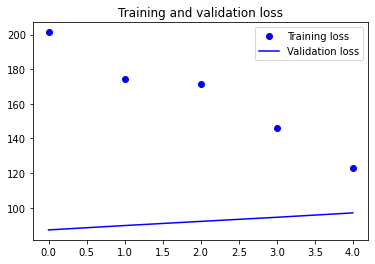

In [12]:
import matplotlib.pyplot as plt

# plot training and validation loss
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(30)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
# test error
model.evaluate_generator(my_test_batch_generator, verbose = 1)

/n/home09/jeryang/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
<ipython-input-7-915182c10d29>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


1/1 [==============================] - 6s 6s/step - loss: 117.8411


117.8410873413086

### extract saliency map

In [14]:
from tensorflow.keras import backend as K
import tf_keras_vis
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

saliency = Saliency(model,
                    clone=True)

def score_function(output):
    return output[:, 0]

In [15]:
# get video directory for extracting saliency map
video_dir = '/n/holylfs05/LABS/jyang_lab/Lab/tiktok_sample/sales_panel/frame/'
video_name = os.listdir(video_dir)

In [16]:
length = 224
width = 224

for video in video_name:    
    count = 0
    y = []
    
    frame_name = os.listdir(video_dir + '/' + video)
    frame_name = natsort.natsorted(frame_name)
    
    if len(frame_name) < 1:
        next
    else:       
        for frame in frame_name:
            if not frame.startswith('.'):
                image = cv2.imread(video_dir + video + '/' + frame)
                image = resize(image , (length,width))
                y.append(image)
                count+=1
    
    y = np.array(y)

    saliency_map = saliency(score_function, y)
    saliency_map = normalize(saliency_map)
    saliency_map = np.reshape(saliency_map, saliency_map.shape[1:4])
    
    out = out_dir + video
    np.save(out, saliency_map)

In [17]:
# py_session()
# 68 modules found
# IPython             	7.22.0                  imageio             	2.9.0                   pygments            	2.8.1
# PIL                 	8.2.0                   ipykernel           	5.3.4                   pyparsing           	2.4.7
# argparse            	1.1                     ipython_genutils    	0.2.0                   pytz                	2021.1
# astunparse          	1.6.3                   jedi                	0.17.2                  re                  	2.2.1
# backcall            	0.2.0                   json                	2.0.9                   requests            	2.31.0
# bottleneck          	1.3.2                   jupyter_client      	6.1.12                  scipy               	1.6.2
# certifi             	2020.12.05              jupyter_core        	4.7.1                   six                 	1.15.0
# cffi                	1.14.5                  keras_preprocessing 	1.1.2                   skimage             	0.18.1
# chardet             	4.0.0                   kiwisolver          	1.3.1                   socks               	1.7.1
# charset_normalizer  	3.3.2                   logging             	0.5.1.2                 tblib               	1.7.0
# colorama            	0.4.4                   matplotlib          	3.3.4                   tensorboard         	2.11.2
# csv                 	1.0                     natsort             	8.4.0                   tensorflow          	2.5.0
# ctypes              	1.1.0                   numpy               	1.22.4                  termcolor           	(1, 1, 0)
# cv2                 	4.8.1                   opt_einsum          	v3.3.0                  tf_keras_vis        	0.8.6
# cycler              	0.10.0                  packaging           	20.9                    tifffile            	2020.10.1
# dateutil            	2.8.1                   pandas              	1.2.4                   traitlets           	5.0.5
# decimal             	1.70                    parso               	0.7.0                   urllib3             	1.26.4
# decorator           	4.4.2                   pexpect             	4.8.0                   wcwidth             	0.2.5
# deprecated          	1.2.14                  pickleshare         	0.7.5                   wrapt               	1.12.1
# distutils           	3.8.8                   platform            	1.0.8                   yaml                	5.4.1
# fsspec              	0.9.0                   prompt_toolkit      	3.0.17                  zlib                	1.0
# h5py                	3.1.0                   ptyprocess          	0.7.0                   zmq                 	20.0.0
# idna                	2.10                    py_session          	0.1.1                   